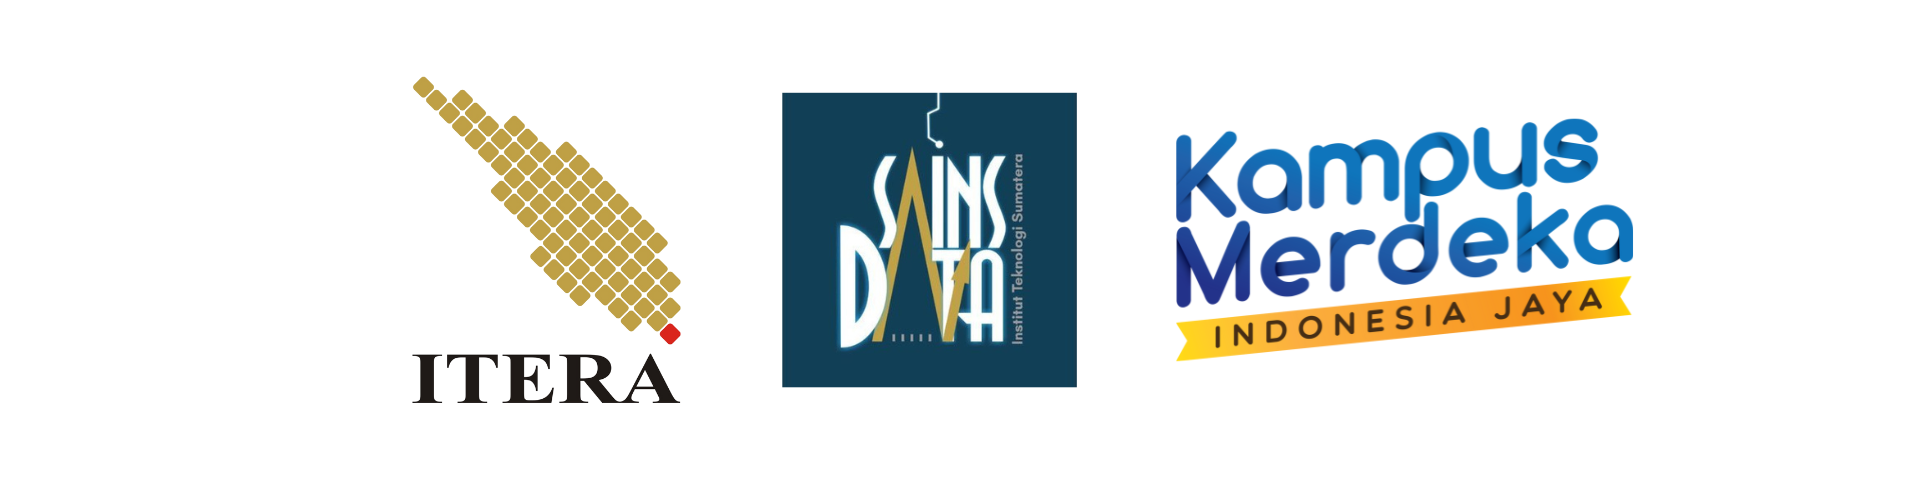

## Sentiment Analysis Using GRU
### GPU Test

In [ ]:
!nvdia-smi

In [2]:
!pip install contraction

Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement contraction (from versions: none)
ERROR: No matching distribution found for contraction
